In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datamodel
import logging
import main
pd.options.mode.chained_assignment = None

In [33]:
from datamodel import OrderDepth, UserId, TradingState, Order

class Trader:

    LIMIT = {
        'AMETHYSTS': 20,
        'STARFRUIT': 20
    }

    starfruit_price_history = []
    starfruit_initial_price = 5000
    ma_window_size = 10

    @staticmethod
    def calculate_wavg_midprice(order_depth):
        sorted_buy_orders = sorted(order_depth.buy_orders.items(), reverse=True)
        sorted_sell_orders = sorted(order_depth.sell_orders.items(), reverse=False)
        total_volume = 0
        wavg_price = 0
        for p, vol in sorted_buy_orders:
            wavg_price += p * vol
            total_volume += vol
        for p, vol in sorted_sell_orders:
            vol = abs(vol)
            wavg_price += p * vol
            total_volume += vol
        wavg_price /= total_volume
        return wavg_price

    @staticmethod
    def calculate_barrier_price(order_depth, barrier=10):
        sorted_buy_orders = sorted(order_depth.buy_orders.items(), reverse=True)
        sorted_sell_orders = sorted(order_depth.sell_orders.items(), reverse=False)
        buy_p_, sell_p_ = -1, -1
        buy_vol_, sell_vol_ = 0, 0
        for p, vol in sorted_buy_orders:
            if vol >= barrier:
                buy_p_, buy_vol_ = p, vol
                break
            elif vol > buy_vol_:
                buy_p_, buy_vol_ = p, vol
        for p, vol in sorted_sell_orders:
            vol = abs(vol)
            if vol >= barrier:
                sell_p_, sell_vol_ = p, vol
                break
            elif vol > buy_vol_:
                sell_p_, sell_vol_ = p, vol
        return buy_p_, sell_p_

    def run(self, state):

        result = {}
        idx = state.timestamp // 100

        for product in state.order_depths:

            current_position = state.position.get(product, 0)
            order_depth = state.order_depths[product]
            orders = []

            if product == "AMETHYSTS":

                sell_capacity = - self.LIMIT[product] - current_position
                buy_capacity = self.LIMIT[product] - current_position

                b, s = self.calculate_barrier_price(order_depth, 1)

                if sell_capacity < 0:
                    orders.append(Order(product, max(10001, 10001), sell_capacity))
                    # orders.append(Order(product, 10001, sell_capacity))
                if buy_capacity > 0:
                    orders.append(Order(product, min(10001, 9999), buy_capacity))
                    # orders.append(Order(product, 9999, buy_capacity))

            if product == "STARFRUIT":

                wavg_price = self.calculate_wavg_midprice(order_depth)

                self.starfruit_price_history.append(wavg_price)

                ll = min(self.ma_window_size, len(self.starfruit_price_history))
                mp = 0
                for i in range(1, ll + 1):
                    mp += self.starfruit_price_history[-i]
                mp = int(mp / ll)

                if idx < 250:
                    sell_capacity = - self.LIMIT[product] - current_position + 15
                    buy_capacity = self.LIMIT[product] - current_position - 15
                    sell_margin, buy_margin = 2, 2
                elif idx <= 9500:
                    if mp <= self.starfruit_initial_price:
                        sell_capacity = - self.LIMIT[product] - current_position
                        buy_capacity = self.LIMIT[product] - current_position - 15
                        sell_margin, buy_margin = 1, 2
                    elif mp >= self.starfruit_initial_price:
                        sell_capacity = - self.LIMIT[product] - current_position + 15
                        buy_capacity = self.LIMIT[product] - current_position
                        sell_margin, buy_margin = 2, 1
                else:
                    if mp <= self.starfruit_initial_price:
                        sell_capacity = - self.LIMIT[product] - current_position
                        buy_capacity = self.LIMIT[product] - current_position - 20
                        sell_margin, buy_margin = 1, 2
                    elif mp >= self.starfruit_initial_price:
                        sell_capacity = - self.LIMIT[product] - current_position + 20
                        buy_capacity = self.LIMIT[product] - current_position
                        sell_margin, buy_margin = 2, 1

                if sell_capacity < 0:
                    orders.append(Order(product, mp + sell_margin, sell_capacity))
                if buy_capacity > 0:
                    orders.append(Order(product, mp - buy_margin, buy_capacity))

            result[product] = orders

        return result, None, "Taeja"

In [34]:
from dataclasses import dataclass
from collections import defaultdict


POSITION_LIMIT = {
    'AMETHYSTS': 20,
    'STARFRUIT': 20
}


@dataclass
class result:
    """Class for simulation result"""
    import logging
    logging.basicConfig(format='%(message)s', level=logging.INFO)

    pnl: defaultdict
    transactions: pd.DataFrame
    mid_price: defaultdict
    position: defaultdict

    def summary(self, verbose=False):

        product_list = list(self.pnl.keys())
        product_list.remove('total')

        for k, v in self.pnl.items():
            logging.info(f" -> {k}: {v[-1]:.1f}")
        
        logging.info('\n')

        total_transaction_amt = len(self.transactions)        
        logging.info(f"# of transaction is {total_transaction_amt:d}")
        for k in product_list:
            buy = self.transactions[(self.transactions['Product'] == k) & (self.transactions['B/S'] == 'B')]
            sell = self.transactions[(self.transactions['Product'] == k) & (self.transactions['B/S'] == 'S')]
            total_v = len(buy) + len(sell)
            logging.info(f" -> {k}: B({len(buy):>3d}) + S({len(sell):>3d})")

        if not verbose:
            fig, ax = plt.subplots(1, 1)
            legends = []
            for k, v in self.pnl.items():
                ax.set_title("PnL")
                ax.plot(v)
                legends.append(k)
            ax.legend(legends)

        else:
            nrow = len(self.pnl) - 1
            fig, axs = plt.subplots(nrow, 2, figsize=(20, 12))
            for i, (k, v) in enumerate(self.pnl.items()):
                if k != 'total':
                    axs[i][0].set_title(k)
                    axs[i][0].plot(v)   
                    axs[i][0].legend(["Pnl"])
              
                    axs[i][1].set_title(k)
                    axs[i][1].plot(self.position[k])
                    ax2 = axs[i][1].twinx()
                    ax2.plot(self.mid_price[k], c='orange', alpha=0.5)
                    axs[i][1].set_ylim([-POSITION_LIMIT[k], POSITION_LIMIT[k]])


class Simulator:

    def __init__(self, scenario_path=None, df=None):

        if df is not None:
            self.df = df
        elif scenario_path is not None:
            self.df = pd.read_csv(scenario_path, sep=';')
    
        self.product = self.df['product'].unique().tolist()
        self.last_price_ = defaultdict(list)

        self.traderdata = ""
        self.timestamp = sorted(self.df['timestamp'].unique())
        self.order_depths_ = dict()
        self.own_trades_ = dict()
        self.listings_ = dict()
        self.market_trades_ = dict()
        self.position_ = defaultdict(lambda: [0])
        self.observations_ = dict() 
        self.pnl_ = defaultdict(lambda: [0])
        self.cost_basis_ = defaultdict(float)
        self.records = pd.DataFrame(columns=['TimeStamp', 'B/S', 'Quantity', "Product", 'Price'])


    def _clear(self):
        self.order_depths_.clear()
        self.own_trades_.clear()
        self.listings_.clear()
        self.market_trades_.clear()
        self.observations_.clear() 


    def _breach_or_not(self):
        for k, v in POSITION_LIMIT.items():
            if abs(self.position_[k][-1]) > v:
                return True
        return False


    def _settle(self, orders, timestamp):

        for product in self.product:
            
            new_position = self.position_[product][-1]

            if product in orders:
                
                order_depth = self.order_depths_[product]
                order = orders[product]

                sorted_buy_orders = sorted(order_depth.buy_orders.items(), reverse=True)
                sorted_sell_orders = sorted(order_depth.sell_orders.items(), reverse=False)

                for o in order:
                    price, quantity = o.price, o.quantity

                    if quantity > 0:
                        for p, vol in sorted_sell_orders:
                            p, vol = int(p), int(vol)
                            if p <= price and quantity > 0:
                                done = min(quantity, abs(vol))
                                quantity -= done
                                new_position += done 
                                if product not in self.own_trades_:
                                    self.own_trades_[product] = [datamodel.Trade(product, p, done, self.traderdata, "", timestamp)]
                                else:
                                    self.own_trades_[product].append(datamodel.Trade(product, p, done, self.traderdata, "", timestamp))

                                self.cost_basis_[product] -= done * p

                                self.records.loc[len(self.records)] = timestamp, 'B', done, product, p

                    elif quantity < 0:
                        for p, vol in sorted_buy_orders:
                            p, vol = int(p), int(vol)
                            if p >= price and quantity < 0:
                                done = min(abs(quantity), vol)
                                quantity += done
                                new_position -= done 
                                if product not in self.own_trades_:
                                    self.own_trades_[product] = [datamodel.Trade(product, p, -done, "", self.traderdata, timestamp)]
                                else:
                                    self.own_trades_[product].append(datamodel.Trade(product, p, -done, "", self.traderdata, timestamp))

                                self.cost_basis_[product] += done * p
                                self.records.loc[len(self.records)] = timestamp, 'S', done, product, p
            
            self.position_[product] += [new_position]
            self.pnl_[product] += [ self.cost_basis_[product] + self.last_price_[product][-1] * self.position_[product][-1] ]

        self.pnl_['total'] += [ sum(self.pnl_[product][-1] for product in self.product) ]


    def simulate(self, Trader):

        for timestamp_ in self.timestamp:
            
            self._clear()

            tmp = self.df[self.df['timestamp'] == timestamp_]
            for _, row in tmp.iterrows():

                product_ = row['product']
                self.last_price_[product_] += [row['mid_price']]

                self.listings_[product_] = datamodel.Listing(product_, product_, 'SEASHELLS')
                self.order_depths_[product_] = datamodel.OrderDepth()

                dict_ = dict()
                for i in (1, 2, 3):
                    if row[f'bid_volume_{i}'] != 0 and not np.isnan(row[f'bid_volume_{i}']):
                        dict_[row[f'bid_price_{i}']] = row[f'bid_volume_{i}']
                self.order_depths_[product_].buy_orders = dict_
                
                dict_ = dict()
                for i in (1, 2, 3):
                    if row[f'ask_volume_{i}'] != 0 and not np.isnan(row[f'ask_volume_{i}']):
                        dict_[row[f'ask_price_{i}']] = -row[f'ask_volume_{i}']
                self.order_depths_[product_].sell_orders = dict_

            position__ = {k: v[-1] for k, v in self.position_.items()}

            tradingstate_ = datamodel.TradingState("", timestamp_, self.listings_, self.order_depths_, self.own_trades_, self.market_trades_, position__, self.observations_)

            orders, _, name = Trader.run(tradingstate_)

            self._settle(orders, timestamp_)

            if self._breach_or_not():
                return f"Breach Occurs at timestamp {timestamp_}"
        
        return result(self.pnl_, self.records, self.last_price_, self.position_)

 -> AMETHYSTS: 7780.0
 -> STARFRUIT: 4634.0
 -> total: 12414.0


# of transaction is 2681
 -> AMETHYSTS: B(813) + S(810)
 -> STARFRUIT: B(416) + S(642)


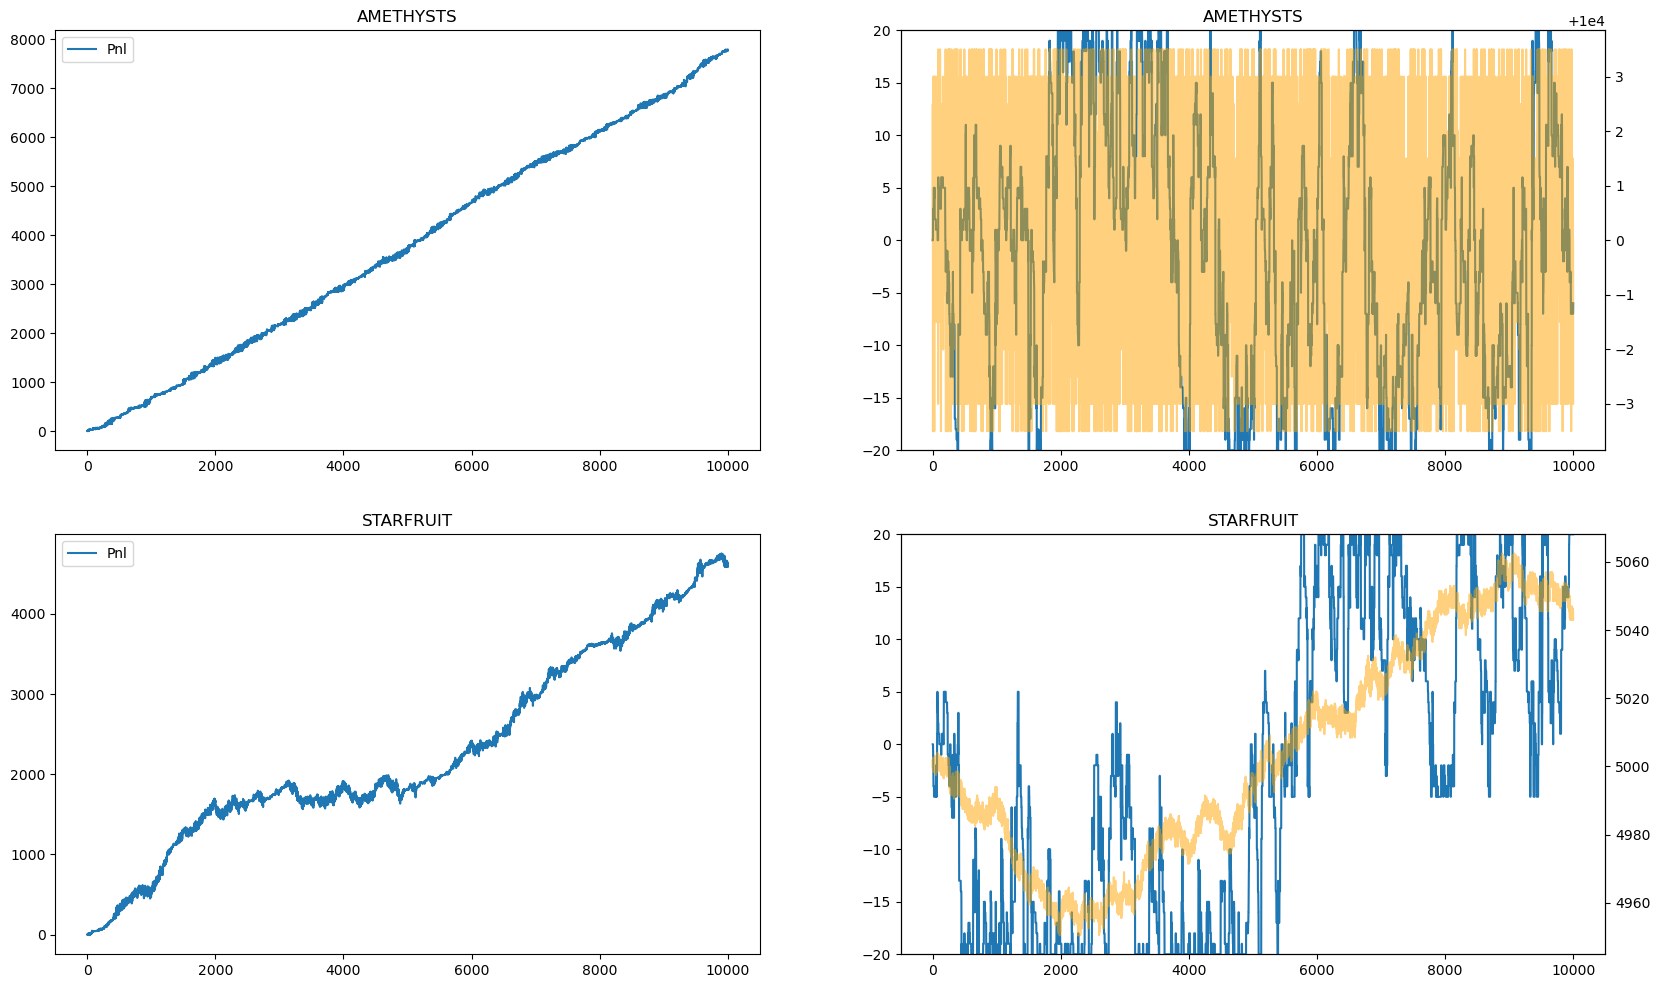

In [35]:
day = -2
simulator = Simulator(rf"/Users/ysc/Desktop/imcProsperity/round1/prices_round_1_day_{day}.csv")
trader1 = Trader()
res = simulator.simulate(trader1)
res.summary(verbose=True)

In [58]:
m1(910, 920)

17.82216

In [45]:
N = 100

ppl = np.random.randint(900, 1001, N)


In [107]:
p = np.arange(1, 101) / np.arange(1, 101).sum()

def m1(first_bid, second_bid):

    N, M = 1000, 10000
    res = 0
    for i in range(N):
        ppl = np.random.choice(np.arange(901, 1001), p=p, size=M)
        n1 = np.sum(ppl <= first_bid)
        n2 = np.sum(ppl <= second_bid) - n1
        profit = n1 * (1000 - first_bid) + n2 * (1000 - second_bid)
        res += profit
    return res / N / M

In [108]:
res = np.zeros((101, 101))

for i in range(940, 981):
    for j in range(i+1, 991):
        res[i-900][j-900] = m1(i, j)

In [106]:
np.max(res)

20.56839

In [90]:
N = 1000000


(array([  187.,   413.,   552.,   808.,  1004.,  1236.,  1407.,  1580.,
         1786.,  2015.,  2189.,  2272.,  2653.,  2792.,  2973.,  3138.,
         3441.,  3581.,  3743.,  3891.,  4069.,  4457.,  4581.,  4794.,
         4970.,  5209.,  5406.,  5532.,  5673.,  5982.,  6231.,  6325.,
         6568.,  6682.,  6857.,  7068.,  7238.,  7565.,  7689.,  8092.,
         8110.,  8236.,  8576.,  8745.,  8952.,  9194.,  9235.,  9714.,
         9832.,  9787., 10108., 10356., 10344., 10555., 10790., 11086.,
        11306., 11577., 11593., 11724., 12196., 12329., 12344., 12795.,
        12840., 13126., 13270., 13376., 13496., 13893., 14185., 14098.,
        14321., 14510., 14870., 14967., 15165., 15397., 15460., 15766.,
        16001., 16129., 16610., 16685., 16681., 16913., 17231., 17384.,
        17720., 18042., 18058., 18251., 18383., 18718., 18626., 19168.,
        19221., 19611., 19596., 20099.]),
 array([ 901.  ,  901.99,  902.98,  903.97,  904.96,  905.95,  906.94,
         907.93,  908.9

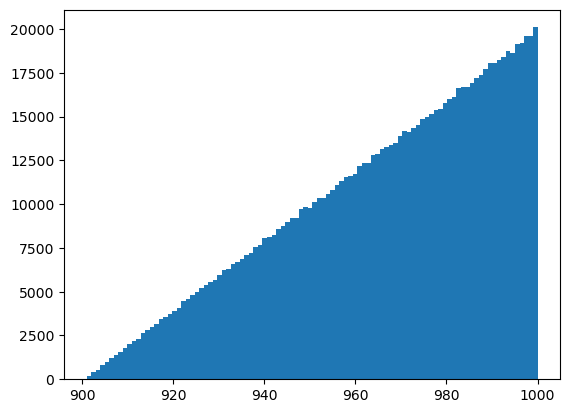

In [91]:
plt.hist(samples, bins=100)

In [82]:
len(p)

99